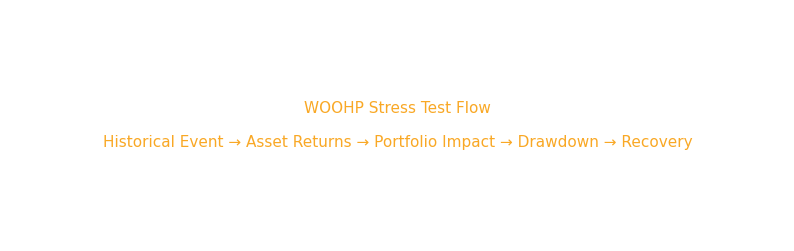

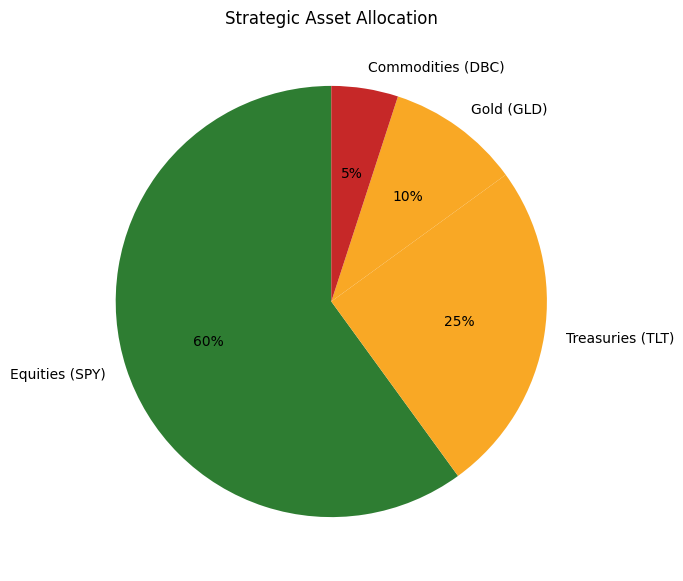

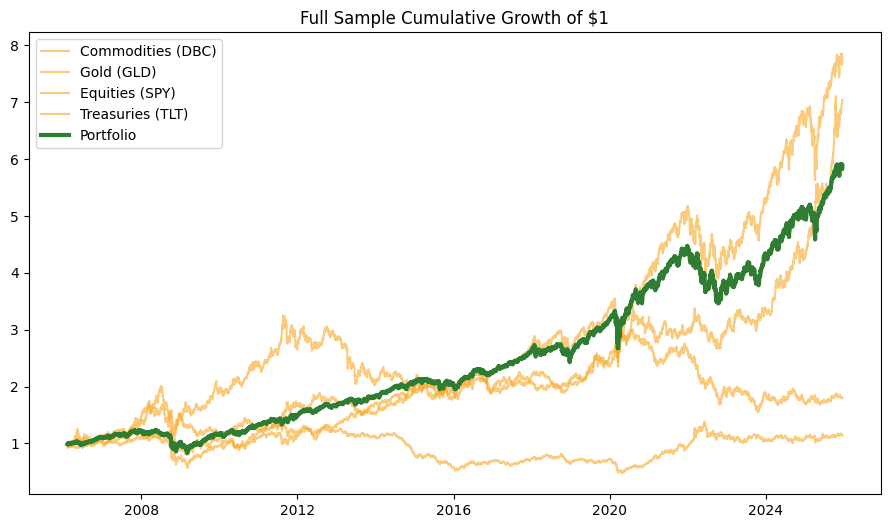

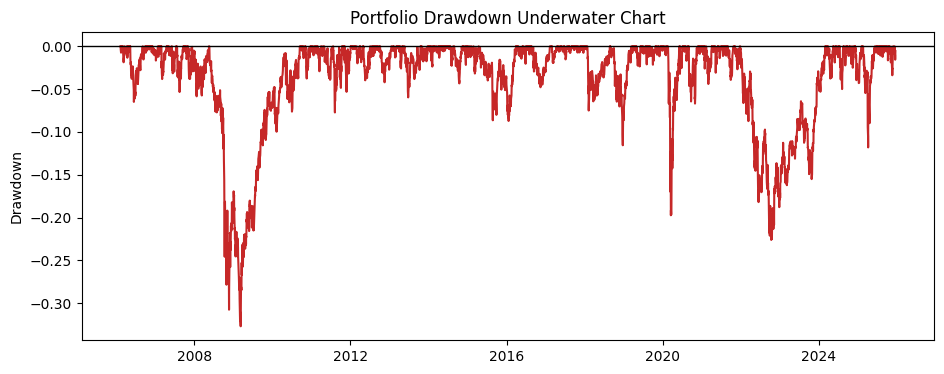

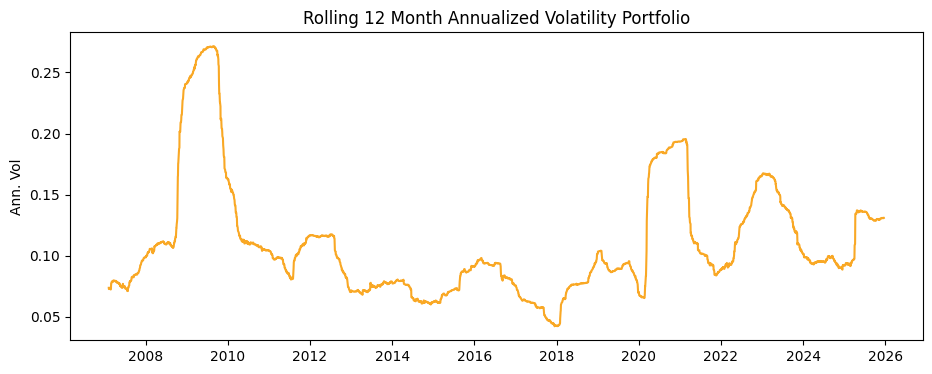

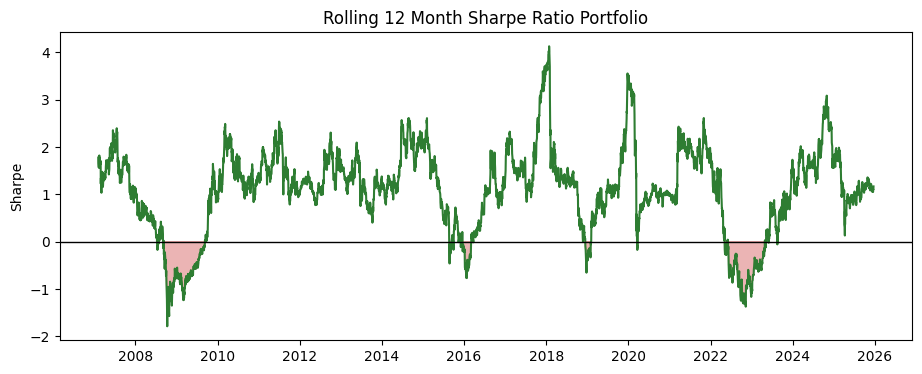

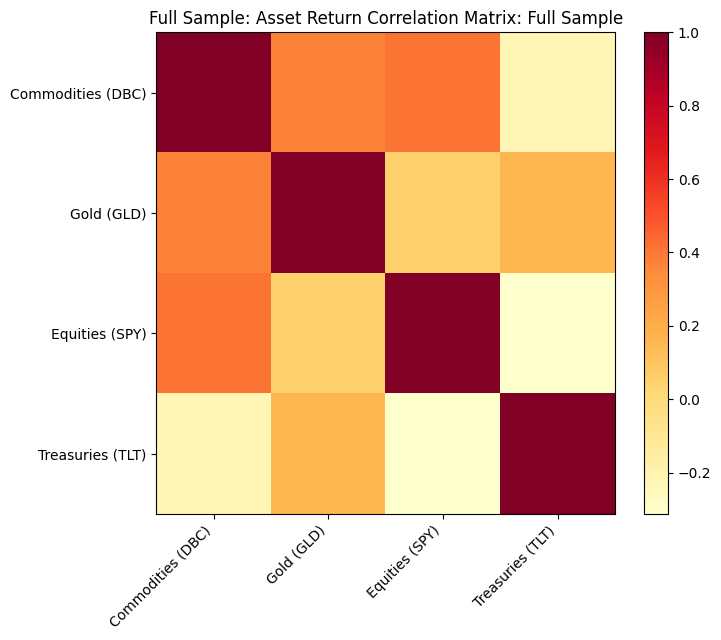

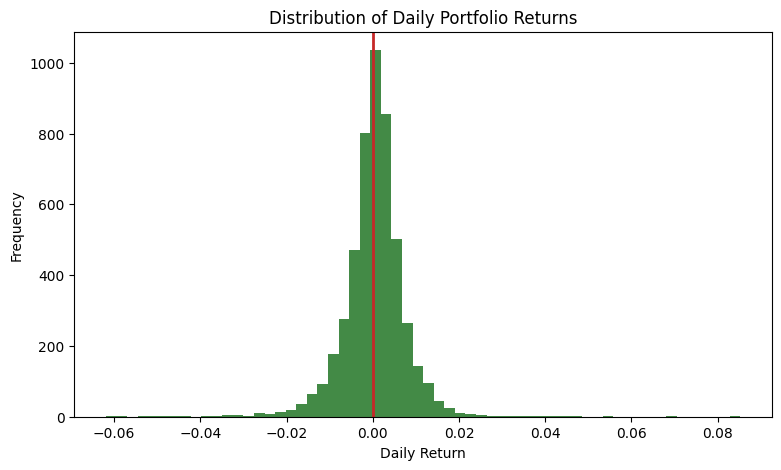

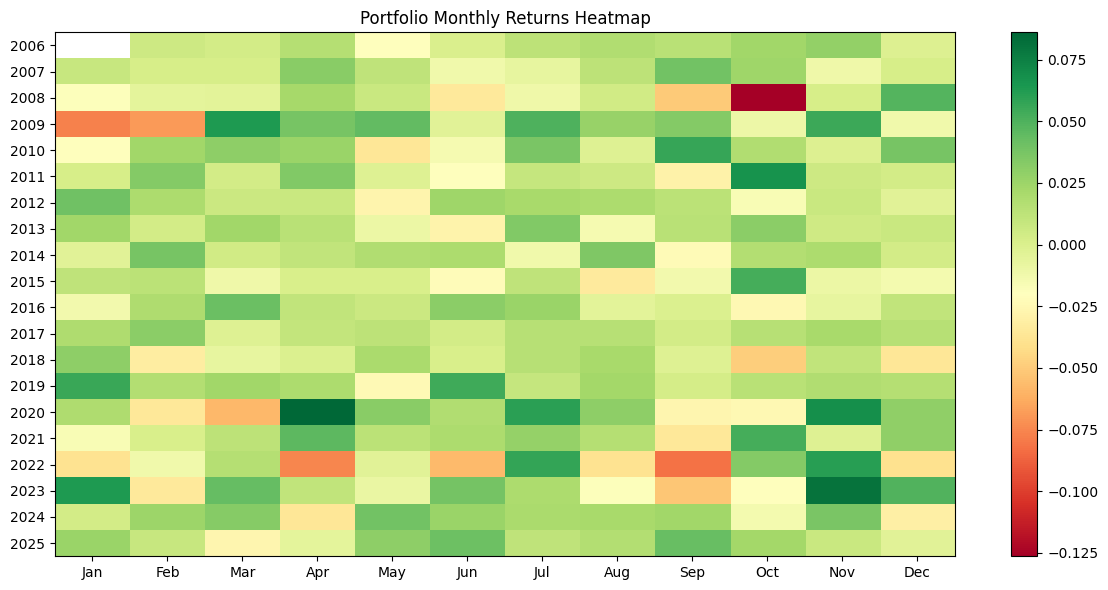

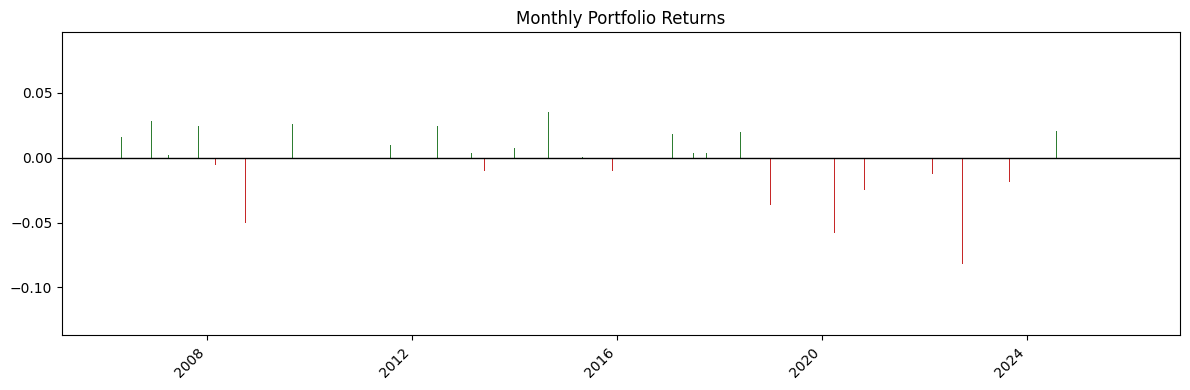

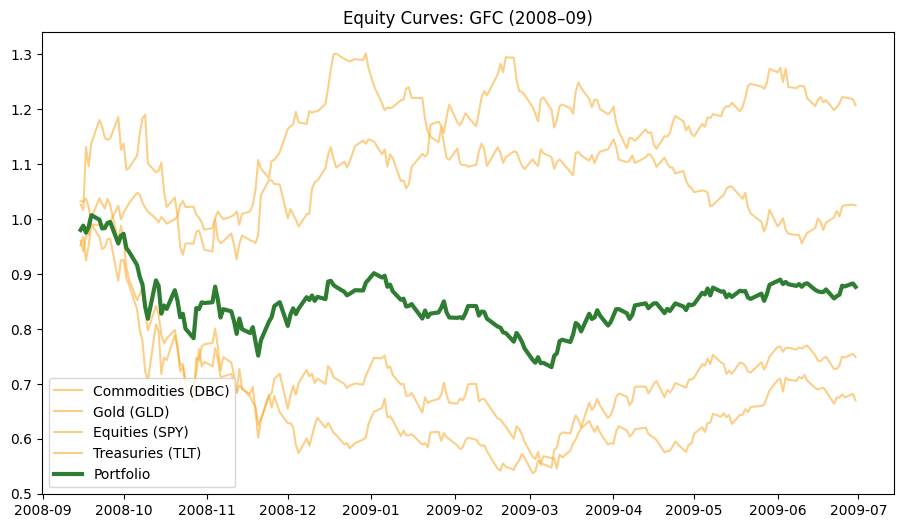

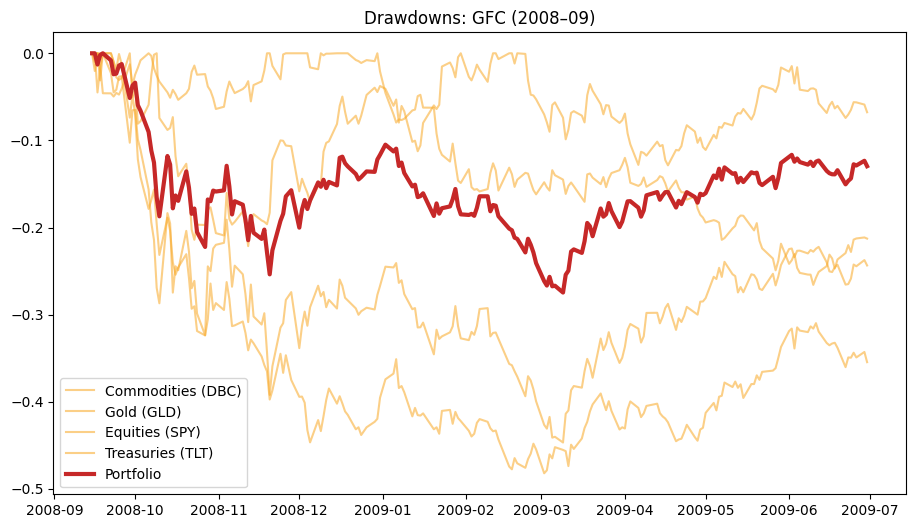

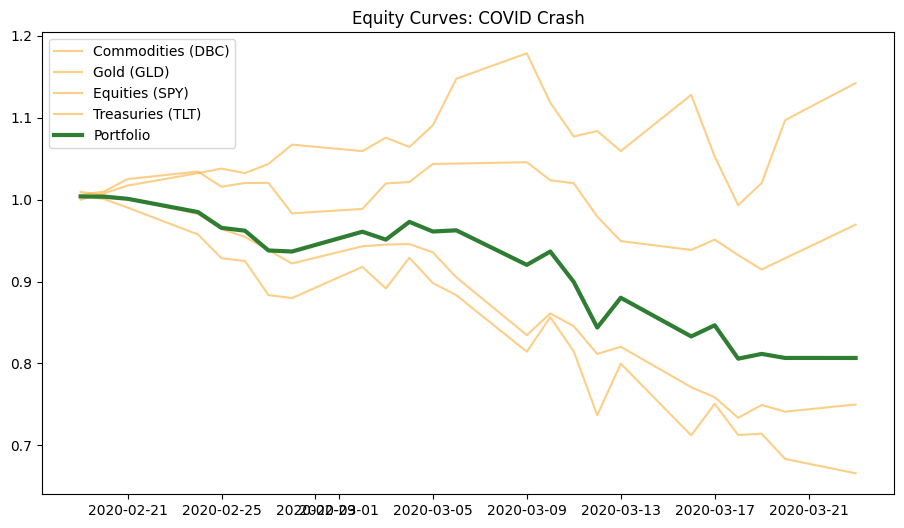

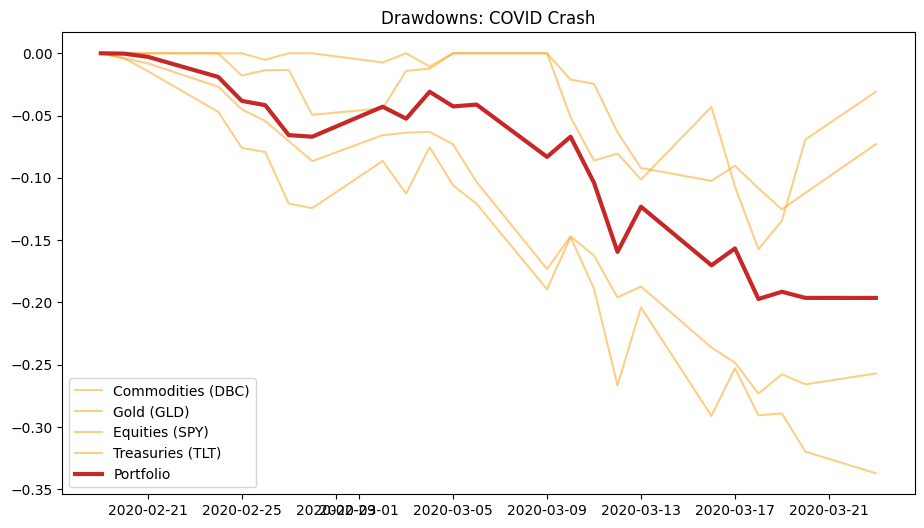

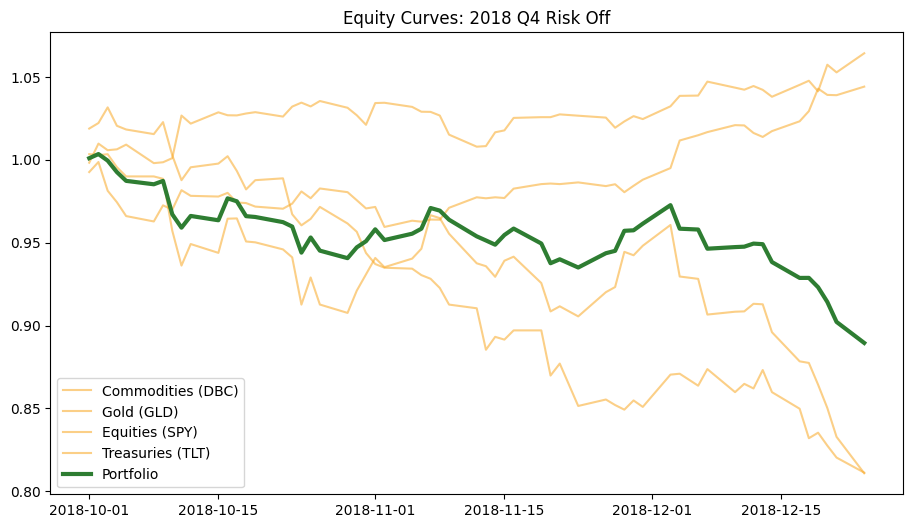

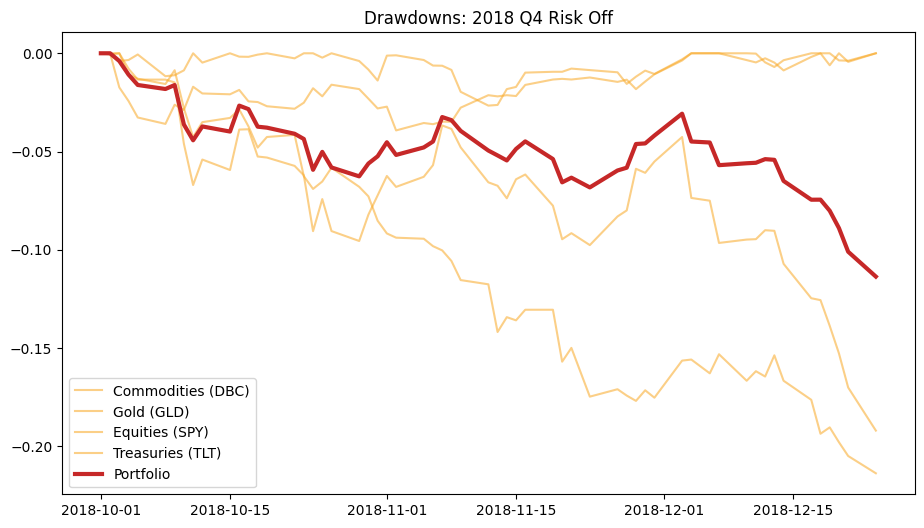

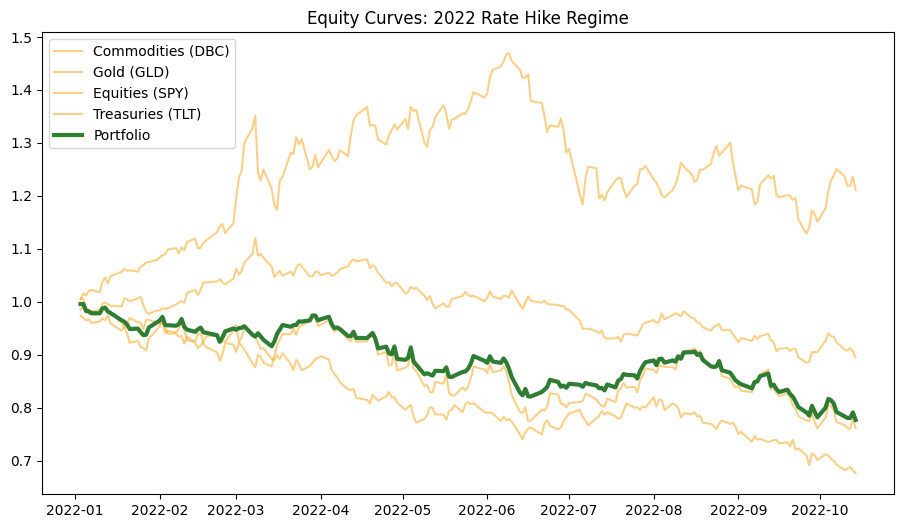

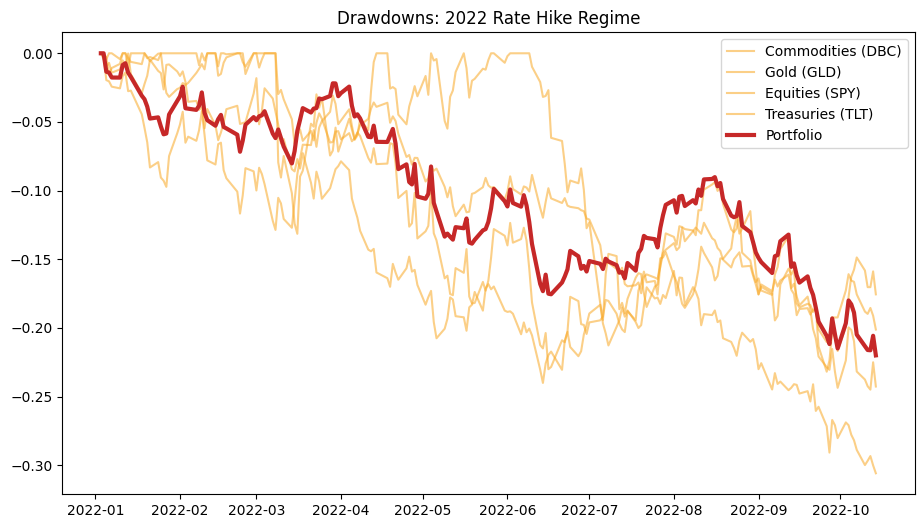


=== Stress Test Summary: Portfolio During Each Event ===
                       TotalReturn  MaxDrawdown  AnnVol  WorstDay  BestDay  \
Event                                                                        
GFC (2008–09)               -0.123       -0.275   0.298    -0.058    0.085   
COVID Crash                 -0.193       -0.197   0.419    -0.062    0.043   
2018 Q4 Risk Off            -0.111       -0.114   0.124    -0.020    0.014   
2022 Rate Hike Regime       -0.223       -0.220   0.162    -0.034    0.024   

                       Sharpe  
Event                          
GFC (2008–09)          -0.410  
COVID Crash            -5.153  
2018 Q4 Risk Off       -3.968  
2022 Rate Hike Regime  -1.906  


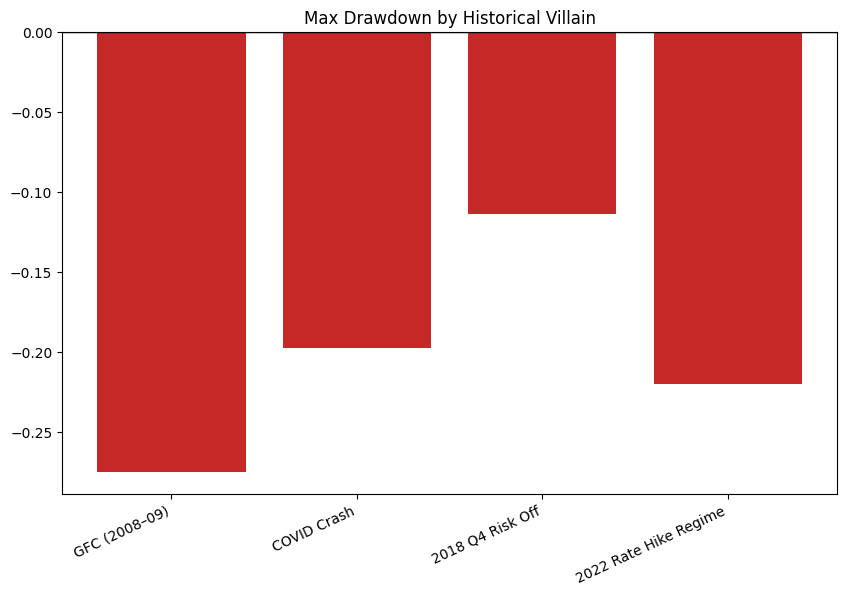

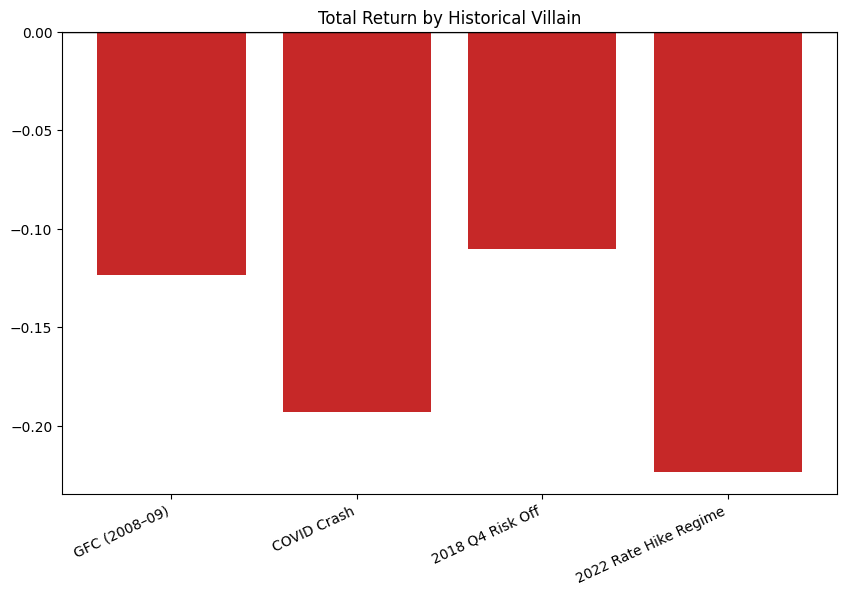

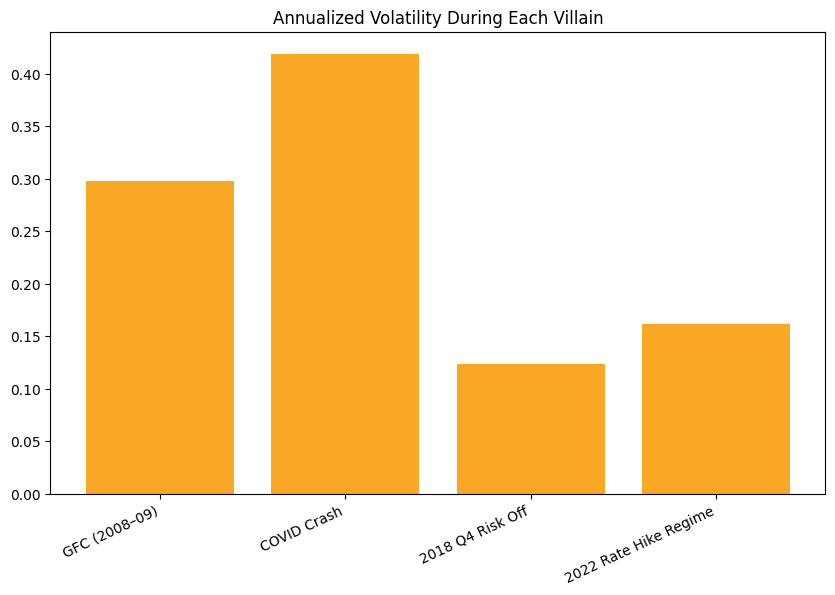

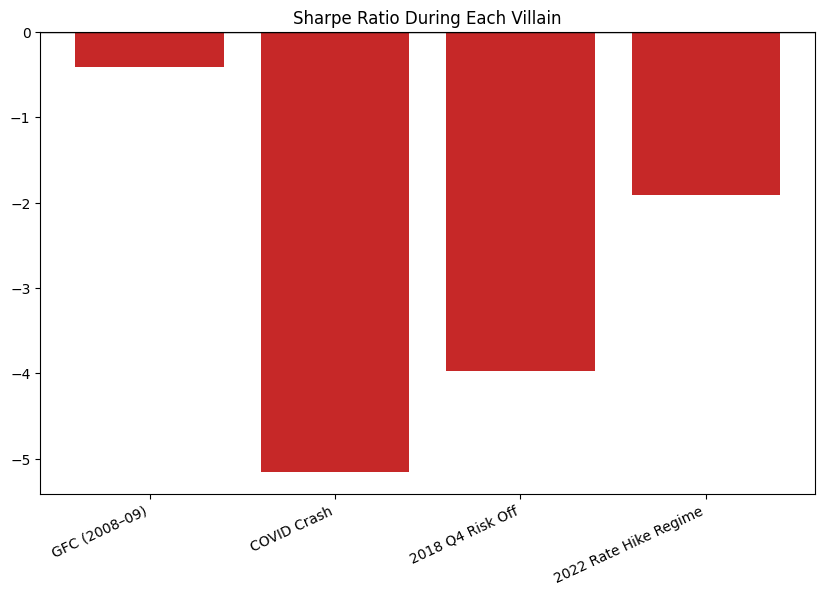

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

#Risk color palette: Red, Yellow, Green
#-----------------------------------------------------------------------------------------------------------------------------------------
RISK_GREEN  = "#2E7D32"   #Green for samantha = stable & positive
RISK_YELLOW = "#F9A825"   #Yellow for Alex = caution
RISK_RED    = "#C62828"   #Red for Clover (yeah I know a clover is green, whatever stay on theme of the shoe) = stress & drawdown

#step 1 Portfolio definition
#-----------------------------------------------------------------------------------------------------------------------------------------
assets = {
    "Equities (SPY)": "SPY",
    "Treasuries (TLT)": "TLT",
    "Gold (GLD)": "GLD",
    "Commodities (DBC)": "DBC"
}

weights = pd.Series({
    "Equities (SPY)": 0.60,
    "Treasuries (TLT)": 0.25,
    "Gold (GLD)": 0.10,
    "Commodities (DBC)": 0.05
})
weights = weights / weights.sum()

start_all = "2006-01-01"
end_all   = "2025-12-20"

price = yf.download(
    list(assets.values()),
    start=start_all,
    end=end_all,
    auto_adjust=True,
    progress=False
)["Close"]

price = price.rename(columns={v: k for k, v in assets.items()})
price = price.ffill().dropna()

rets = price.pct_change().dropna()
port_rets = (rets * weights).sum(axis=1)

#step 2 Historical stress events (the baddie villains)
#-----------------------------------------------------------------------------------------------------------------------------------------
events = {
    "GFC (2008–09)": ("2008-09-15", "2009-06-30"),
    "COVID Crash": ("2020-02-19", "2020-03-23"),
    "2018 Q4 Risk Off": ("2018-10-01", "2018-12-24"),
    "2022 Rate Hike Regime": ("2022-01-03", "2022-10-14")
}

TRADING_DAYS = 252

def equity_curve(r):
    return (1 + r).cumprod()

def drawdown(eq):
    peak = eq.cummax()
    return eq / peak - 1

def ann_vol(r):
    return r.std() * np.sqrt(TRADING_DAYS)

def sharpe(r, rf_annual=0.00):
    rf_daily = (1 + rf_annual) ** (1 / TRADING_DAYS) - 1
    excess = r - rf_daily
    return (excess.mean() / excess.std()) * np.sqrt(TRADING_DAYS)

def perf_stats(r):
    eq = equity_curve(r)
    dd = drawdown(eq)
    return {
        "TotalReturn": eq.iloc[-1] - 1,
        "MaxDrawdown": dd.min(),
        "AnnVol": ann_vol(r),
        "WorstDay": r.min(),
        "BestDay": r.max(),
        "Sharpe": sharpe(r)
    }

#step 3 WOOHP Diagram
#-----------------------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(10, 3))
plt.axis("off")
plt.text(
    0.5, 0.5,
    "WOOHP Stress Test Flow\n\n"
    "Historical Event → Asset Returns → Portfolio Impact → Drawdown → Recovery",
    ha="center", va="center", fontsize=11, color=RISK_YELLOW
)
plt.show()

#step 4 Trad fin vis
#-----------------------------------------------------------------------------------------------------------------------------------------

#Allocation pie
plt.figure(figsize=(7,7))
plt.pie(
    weights.values,
    labels=weights.index,
    autopct="%1.0f%%",
    startangle=90,
    colors=[RISK_GREEN, RISK_YELLOW, RISK_YELLOW, RISK_RED]
)
plt.title("Strategic Asset Allocation")
plt.show()

#Cumulative growth of $1 (assets + portfolio)
eq_assets_full = equity_curve(rets)
eq_port_full = equity_curve(port_rets)

plt.figure(figsize=(11,6))
for col in eq_assets_full.columns:
    plt.plot(eq_assets_full[col], color=RISK_YELLOW, alpha=0.6, label=col)
plt.plot(eq_port_full, color=RISK_GREEN, linewidth=3, label="Portfolio")
plt.title("Full Sample Cumulative Growth of $1")
plt.legend()
plt.show()

#Underwater drawdown aka the portfolio
dd_port_full = drawdown(eq_port_full)

plt.figure(figsize=(11,4))
plt.plot(dd_port_full, color=RISK_RED)
plt.axhline(0, color="black", linewidth=1)
plt.title("Portfolio Drawdown Underwater Chart")
plt.ylabel("Drawdown")
plt.show()

#Rolling a small 12 annualized volatility
rolling_vol = port_rets.rolling(TRADING_DAYS).std() * np.sqrt(TRADING_DAYS)

plt.figure(figsize=(11,4))
plt.plot(rolling_vol, color=RISK_YELLOW)
plt.title("Rolling 12 Month Annualized Volatility Portfolio")
plt.ylabel("Ann. Vol")
plt.show()

#Rolling 12M Sharpe: green above 0, red below 0
rf_annual = 0.00
rf_daily = (1 + rf_annual) ** (1 / TRADING_DAYS) - 1
roll_excess = port_rets - rf_daily
rolling_sharpe = (roll_excess.rolling(TRADING_DAYS).mean() /
                  roll_excess.rolling(TRADING_DAYS).std()) * np.sqrt(TRADING_DAYS)

plt.figure(figsize=(11,4))
plt.plot(rolling_sharpe, color=RISK_GREEN)
plt.fill_between(
    rolling_sharpe.index,
    rolling_sharpe,
    0,
    where=rolling_sharpe < 0,
    color=RISK_RED,
    alpha=0.35
)
plt.axhline(0, color="black", linewidth=1)
plt.title("Rolling 12 Month Sharpe Ratio Portfolio")
plt.ylabel("Sharpe")
plt.show()

#Correlation heatmap aka assets
corr = rets.corr()

plt.figure(figsize=(7.5,6.5))
plt.imshow(corr.values, cmap="YlOrRd", aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Full Sample: Asset Return Correlation Matrix: Full Sample")
plt.tight_layout()
plt.show()

#Return distribution portfolio with loss line
plt.figure(figsize=(9,5))
plt.hist(port_rets, bins=60, color=RISK_GREEN, alpha=0.9)
plt.axvline(0, color=RISK_RED, linewidth=2)
plt.title("Distribution of Daily Portfolio Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

#Monthly returns heatmap portfolio
monthly = port_rets.resample("ME").apply(lambda x: (1 + x).prod() - 1)
heat = monthly.to_frame("ret")
heat["Year"] = heat.index.year
heat["Month"] = heat.index.month
heat_pivot = heat.pivot(index="Year", columns="Month", values="ret").sort_index()

plt.figure(figsize=(12,6))
plt.imshow(heat_pivot.values, cmap="RdYlGn", aspect="auto")
plt.colorbar()
plt.yticks(range(len(heat_pivot.index)), heat_pivot.index)
plt.xticks(
    range(12),
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
)
plt.title("Portfolio Monthly Returns Heatmap")
plt.tight_layout()
plt.show()

#Monthly returns bar chart
plt.figure(figsize=(12,4))
bar_colors = [RISK_GREEN if v >= 0 else RISK_RED for v in monthly.values]
plt.bar(monthly.index, monthly.values, color=bar_colors)
plt.axhline(0, color="black", linewidth=1)
plt.title("Monthly Portfolio Returns")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#Step 5 Event diagnostics baddie villains + event visuals
#-----------------------------------------------------------------------------------------------------------------------------------------
summary = []

for name, (s, e) in events.items():
    r_assets = rets.loc[s:e]
    r_port = port_rets.loc[s:e]

    eq_assets = equity_curve(r_assets)
    eq_port = equity_curve(r_port)

    dd_assets = drawdown(eq_assets)
    dd_port = drawdown(eq_port)

    stats = perf_stats(r_port)
    stats["Event"] = name
    summary.append(stats)
    
    #Equity curves during event 
    #assets = yellow 
    #portfolio = green
    plt.figure(figsize=(11,6))
    for col in eq_assets.columns:
        plt.plot(eq_assets[col], color=RISK_YELLOW, alpha=0.55, label=col)
    plt.plot(eq_port, color=RISK_GREEN, linewidth=3, label="Portfolio")
    plt.title(f"Equity Curves: {name}")
    plt.legend()
    plt.show()

    #Drawdowns during event
    #assets = yellow
    #portfolio = red
    plt.figure(figsize=(11,6))
    for col in dd_assets.columns:
        plt.plot(dd_assets[col], color=RISK_YELLOW, alpha=0.55, label=col)
    plt.plot(dd_port, color=RISK_RED, linewidth=3, label="Portfolio")
    plt.title(f"Drawdowns: {name}")
    plt.legend()
    plt.show()

summary_df = pd.DataFrame(summary).set_index("Event")

print("\n=== Stress Test Summary: Portfolio During Each Event ===")
print(summary_df.round(3))

#Max drawdown by villain = red
plt.figure(figsize=(10,6))
plt.bar(summary_df.index, summary_df["MaxDrawdown"], color=RISK_RED)
plt.title("Max Drawdown by Historical Villain")
plt.xticks(rotation=25, ha="right")
plt.axhline(0, color="black", linewidth=1)
plt.show()

#Total return by villain: green & red depending on sign
plt.figure(figsize=(10,6))
tot_colors = [RISK_GREEN if v >= 0 else RISK_RED for v in summary_df["TotalReturn"].values]
plt.bar(summary_df.index, summary_df["TotalReturn"], color=tot_colors)
plt.title("Total Return by Historical Villain")
plt.xticks(rotation=25, ha="right")
plt.axhline(0, color="black", linewidth=1)
plt.show()

#Annualized vol by villain = yellow
plt.figure(figsize=(10,6))
plt.bar(summary_df.index, summary_df["AnnVol"], color=RISK_YELLOW)
plt.title("Annualized Volatility During Each Villain")
plt.xticks(rotation=25, ha="right")
plt.show()

#Sharpe by villain = green & red depending on sign
plt.figure(figsize=(10,6))
sh_colors = [RISK_GREEN if v >= 0 else RISK_RED for v in summary_df["Sharpe"].values]
plt.bar(summary_df.index, summary_df["Sharpe"], color=sh_colors)
plt.title("Sharpe Ratio During Each Villain")
plt.xticks(rotation=25, ha="right")
plt.axhline(0, color="black", linewidth=1)
plt.show()
